In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# plot best threshold for f1 score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')


In [2]:
df = pd.read_csv('data/train_cleaned.csv')
df_labels = pd.read_csv('data/labels_q.csv')

In [3]:
df_labels = df_labels[['session_id', 'q1']]

df_labels.columns = ['session_id', 'label']

In [4]:
df = pd.get_dummies(df, columns=['event_name', 'fqid', 'room_fqid', 'fullscreen', 'text_fqid'])

num_cols = ['elapsed_time', 'level', 'room_coor_x', 'room_coor_y', 'event_index', 'elapsed_time_diff']

#scaler = StandardScaler()
#df[num_cols] = scaler.fit_transform(df[num_cols]).astype('float32')

df = df.merge(df_labels, on='session_id')

In [5]:
# sort by session_id and elapsed_time
df = df.sort_values(['session_id', 'elapsed_time'])

In [6]:

def create_sequence(session_id):
    sequence = df[df['session_id'] == session_id]

    X = sequence.drop(['session_id','label'], axis=1).values
    y = sequence['label'].iloc[-1]

    # if sequence is not 220, pad with zeros
    if X.shape[0] < 220:
        X = np.pad(X, ((0, 220-X.shape[0]), (0,0)), 'constant')

    if X.shape[0] > 220:
        X = X[:220]
    return X, y

Xs, ys = [], []

for session_id in df['session_id'].unique():
    X, y = create_sequence(session_id)
    if X.shape[0] > 1: # filter out sessions with only one event
        Xs.append(X)
        ys.append(y)

Xs = np.array(Xs)
ys = np.array(ys)

X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)

# get validation set which is half of the test set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [7]:
from sklearn.metrics import f1_score
import tensorflow as tf
from keras import backend as K



def f1_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    y_true_np = K.eval(y_true)
    y_pred_np = K.eval(y_pred)
    return 1 - f1_score(y_true_np, y_pred_np, average='macro')

In [9]:
from tensorflow.keras.layers import BatchNormalization

learning_rate = 0.0005
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

model = Sequential()
model.add(BatchNormalization(input_shape=(220, X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


#model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True), optimizer=optimizer, metrics=['accuracy'],)

#model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), optimizer='adam', metrics=['accuracy'],)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=32)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/8


2023-04-13 10:48:36.718980: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


590/590 [==============================] - 28s 44ms/step - loss: 0.5839 - accuracy: 0.7252 - val_loss: 0.5694 - val_accuracy: 0.7322
Epoch 2/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5787 - accuracy: 0.7278 - val_loss: 0.5626 - val_accuracy: 0.7373
Epoch 3/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5665 - accuracy: 0.7299 - val_loss: 0.5508 - val_accuracy: 0.7334
Epoch 4/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5591 - accuracy: 0.7299 - val_loss: 0.5495 - val_accuracy: 0.7364
Epoch 5/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5577 - accuracy: 0.7286 - val_loss: 0.5511 - val_accuracy: 0.7334
Epoch 6/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5544 - accuracy: 0.7307 - val_loss: 0.5437 - val_accuracy: 0.7351
Epoch 7/8
590/590 [==============================] - 25s 43ms/step - loss: 0.5500 - accuracy: 0.7313 - val_loss: 0.5456 - val_accuracy: 0.7364
Epoch 8/8

74/74 [==============================] - 1s 13ms/step
0.6600000000000001
0.6053966595829956


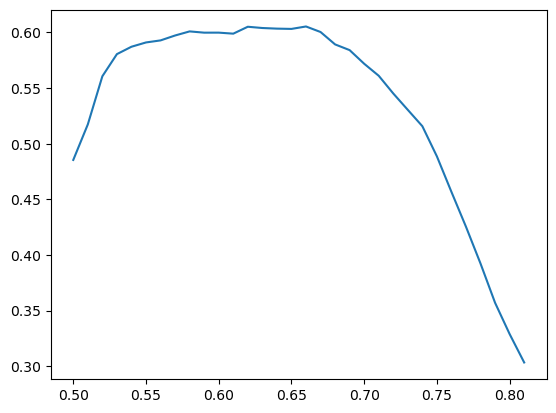

In [10]:
y_pred = model.predict(X_test)


threholds = np.arange(0.5, 0.82, 0.01)
f1_scores = []

for threhold in threholds:
    f1_scores.append(f1_score(y_test, y_pred > threhold, average='macro'))

# get best threshold
best_threshold = threholds[np.argmax(f1_scores)]
print(best_threshold)
print(np.max(f1_scores))

plt.plot(threholds, f1_scores)
plt.show()

74/74 [==============================] - 1s 13ms/step
0.6200000000000001
0.5983486405104799


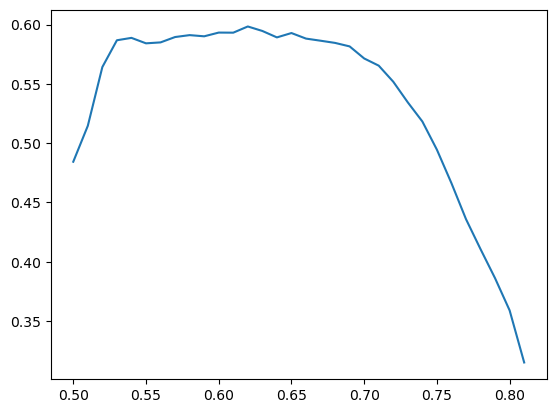

In [11]:
# predict on validation set
y_pred = model.predict(X_val)

threholds = np.arange(0.5, 0.82, 0.01)
f1_scores = []



for threhold in threholds:
    f1_scores.append(f1_score(y_val, y_pred > threhold, average='macro'))


best_threshold = threholds[np.argmax(f1_scores)]
print(best_threshold)
print(np.max(f1_scores))

plt.plot(threholds, f1_scores)
plt.show()

In [12]:
ys.mean()

0.7274849333672863